#  **Home Price Prediction: ML Modeling**

###  **Goals**

- Build a machine learning model to `predict price per square foot` for `residential properties`


- `Separate land listings from built properties` to improve modeling accuracy and allow for search classification


- Use `feature engineering` and `city-level encoding` to enhance `predictive performance`


- Develop a `prediction function` that suggests housing options based on user-defined preferences


- `Rank listings by predicted price per square foot` to highlight the `most desirable and cost-effective properties for the user`


### **Importing Libraries**

In [95]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # tried different models to understand which ones were more accurate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

### **Loading Cleaned Data**

In [27]:
df = pd.read_csv("housing_modeling_data.csv")

### **Split Land vs Property Listings**

- This step ensures better modeling outcomes by handling land and property listings separately

- Land listings often contain values that would be considered outliers in residential property data (very high acreage, missing square footage), but are typical for vacant land

- Separating them prevents skewing the property model and allows `each model to learn from more relevant feature distributions`

In [28]:
df_land = df[df["property_type"] == "Land"].copy()
df_home = df[df["property_type"] != "Land"].copy()

### **Clean Land Data**

- I drop columns not relevant to land (beds, baths) 

- Handled missing values, and filter out listings without a valid city (useful for later encoding)


In [29]:
df_land.drop(columns=["beds", "baths", "square_feet","year_built","price_per_sqft"], inplace=True)
df_land["acres"] = df_land["acres"].fillna(df_land["acres"].median())
df_land.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5090 entries, 0 to 21629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         5090 non-null   object 
 1   city            5086 non-null   object 
 2   price           5090 non-null   int64  
 3   status          5090 non-null   object 
 4   acres           5090 non-null   float64
 5   days_on_market  5090 non-null   int64  
 6   property_type   5090 non-null   object 
 7   hoa_per_month   5090 non-null   int64  
 8   url             5090 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 397.7+ KB


In [30]:
# remove all land values where city is na because the land encoded needs all non nan values
df_land = df_land[df_land["city"].notna()]


### **Encode Land Listings**

- City names are encoded using `average land` prices per city

- This allows the model to learn `geographic patterns`

In [31]:
# land encoded to convert cities to a numerical format to try and increase model accuracy
land_avg_ppsqft = df_land.groupby("city")["price"].mean()
df_land["land_encoded"] = df_land["city"].map(land_avg_ppsqft)

### **Clean Home Data**

- Fill missing values in `beds`, `baths`, and `acres`

- For missing `year_built`, I used recent years to keep the sample

- The distribution for year_built was primarily focued from 2000-present so I randomly chose a value within (2000-2024) as nan replacements 

- This prevents dropping too many rows unnecessarily


In [32]:
df_home["beds"] = df_home["beds"].fillna(0)
df_home["baths"] = df_home["baths"].fillna(0)
df_home["acres"] = df_home["acres"].fillna(df_home["acres"].median())
df_home["year_built"] = df_home["year_built"].apply(
    lambda x: x if not np.isnan(x) else np.random.randint(2000, 2024)
)
df_home.info()
df_home["property_type"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 16541 entries, 4 to 21630
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         16541 non-null  object 
 1   city            16541 non-null  object 
 2   beds            16541 non-null  float64
 3   baths           16541 non-null  float64
 4   price           16541 non-null  int64  
 5   status          16541 non-null  object 
 6   square_feet     16541 non-null  float64
 7   acres           16541 non-null  float64
 8   year_built      16541 non-null  float64
 9   days_on_market  16541 non-null  int64  
 10  property_type   16541 non-null  object 
 11  hoa_per_month   16541 non-null  int64  
 12  url             16541 non-null  object 
 13  price_per_sqft  16541 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 1.9+ MB


property_type
Single Family         11841
Townhouse              2491
Condo                  2114
Multi-Family             83
Large Multi-Family        8
Ranch                     4
Name: count, dtype: int64

### **Remove Outliers From Price On Land Values**
- This will help the model predict Land price values more `accurately`

In [ ]:
# df land - even with land encoder and log prices is still not performing great and can be improved. - removing upper limit values to make land prices more realistic to normal land/home buyers - cutting off land price at 95% quantile 
upper_limit = df_land["price"].quantile(0.95) # cut off around 1 million dollars 
df_land = df_land[df_land["price"] < upper_limit]


### **Encode Categorical Variables In Property DataFrame**

- `One hot endcoded property type` so the model is able to use the values for predicting

- Also, created a `city_encoded` variable that is similar to lands encoded value. Based on `avg sqft by cities` we are easily able to `assign weights` to each `individual city allowing it to be used in predictions`

- The city encoded value in predicting `cut the mae and rmse both by 50% greatly increasing accuracy of predictions.`

In [34]:
df_home = pd.get_dummies(df_home, columns=["property_type"], drop_first=False)
df_home.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16541 entries, 4 to 21630
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   address                           16541 non-null  object 
 1   city                              16541 non-null  object 
 2   beds                              16541 non-null  float64
 3   baths                             16541 non-null  float64
 4   price                             16541 non-null  int64  
 5   status                            16541 non-null  object 
 6   square_feet                       16541 non-null  float64
 7   acres                             16541 non-null  float64
 8   year_built                        16541 non-null  float64
 9   days_on_market                    16541 non-null  int64  
 10  hoa_per_month                     16541 non-null  int64  
 11  url                               16541 non-null  object 
 12  price_per

In [35]:
# calculate average price_per_sqft by city - helps model by around 50%
city_avg_ppsqft = df_home.groupby("city")["price_per_sqft"].mean()
df_home["city_encoded"] = df_home["city"].map(city_avg_ppsqft)


### **Train The Model**

- I aimed to predict price_per_sqft, which helps normalize for home size

- `Log-transforming` the target value `improves performance on heavily skewed data`

- This lets the model compare numeric values a lot easier

- I used the `Random Forest Regressor` due to its ability to `capture nonlinear relationships`. 

- The model is `trained on 80% of the data and tested on the remaining 20%.`


In [93]:
## property model: trying to predict price per square foot
features_property = [
    "city_encoded", "beds", "baths", "square_feet", "acres", "year_built",
    "days_on_market", "hoa_per_month",
    "property_type_Townhouse", "property_type_Condo", "property_type_Single Family",
    "property_type_Multi-Family", "property_type_Ranch"
]

X_prop = df_home[features_property]
y_prop = np.log1p(df_home["price_per_sqft"])  # log1p handles 0 safely

# Train/test split
X_prop_train, X_prop_test, y_prop_train, y_prop_test = train_test_split(X_prop, y_prop, test_size=0.2, random_state=42)

# Train model
model_prop = RandomForestRegressor(random_state=42)
model_prop.fit(X_prop_train, y_prop_train)

# Predict log(price_per_sqft)
y_prop_pred_log = model_prop.predict(X_prop_test)

# Reverse log1p to get actual price_per_sqft values
y_prop_pred = np.expm1(y_prop_pred_log)
y_prop_test_actual = np.expm1(y_prop_test)

# Evaluate in original scale
mae_prop = mean_absolute_error(y_prop_test_actual, y_prop_pred)
rmse_prop = mean_squared_error(y_prop_test_actual, y_prop_pred, squared=False)


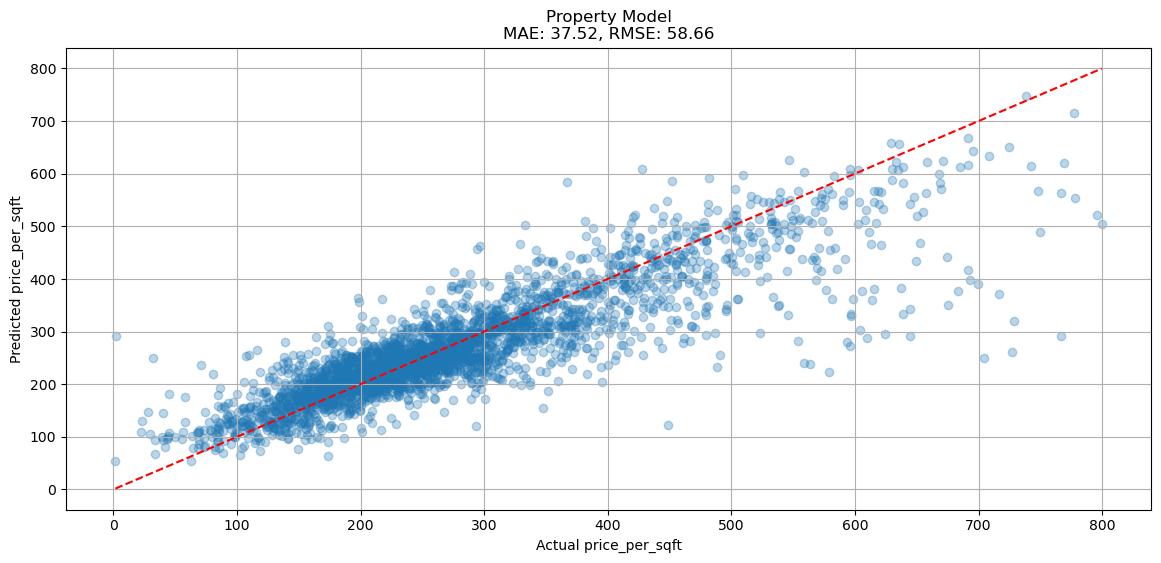

In [94]:
plt.figure(figsize=(14, 6))
plt.scatter(y_prop_test_actual, y_prop_pred, alpha=0.3)  # original scale
plt.plot([y_prop_test_actual.min(), y_prop_test_actual.max()],
         [y_prop_test_actual.min(), y_prop_test_actual.max()],
         'r--')
plt.title(f"Property Model\nMAE: {mae_prop:.2f}, RMSE: {rmse_prop:.2f}")
plt.xlabel("Actual price_per_sqft")
plt.ylabel("Predicted price_per_sqft")
plt.grid(True)
plt.show()


### **Evaluating The Models Performance**
- After several adjustments to the data and model, we achieved a prediction error of `approximately ± $37.50 per square foot.`
- `Log-transforming` the target variable and `encoding cities` based on average price per square foot significantly improved accuracy. Approximately an `80% reduction in error.`
- These improvements are largely due to giving the model more `meaningful, normalized information to learn` from — making `patterns easier to detect` and `reducing the impact of extreme values.`

In [38]:
# Land model: predict log(price)
features_land = ["land_encoded", "acres", "days_on_market", "hoa_per_month"]
X_land = df_land[features_land]
y_land = np.log1p(df_land["price"])  # log1p to handle skew and 0s safely

# Train/test split
X_land_train, X_land_test, y_land_train, y_land_test = train_test_split(
    X_land, y_land, test_size=0.2, random_state=42
)

# Train model
model_land = RandomForestRegressor(random_state=42)
model_land.fit(X_land_train, y_land_train)

# Predict in log space
y_land_pred_log = model_land.predict(X_land_test)

# Convert back to original price scale
y_land_pred = np.expm1(y_land_pred_log)
y_land_test_actual = np.expm1(y_land_test)

# Evaluate
mae_land = mean_absolute_error(y_land_test_actual, y_land_pred)
rmse_land = mean_squared_error(y_land_test_actual, y_land_pred, squared=False)


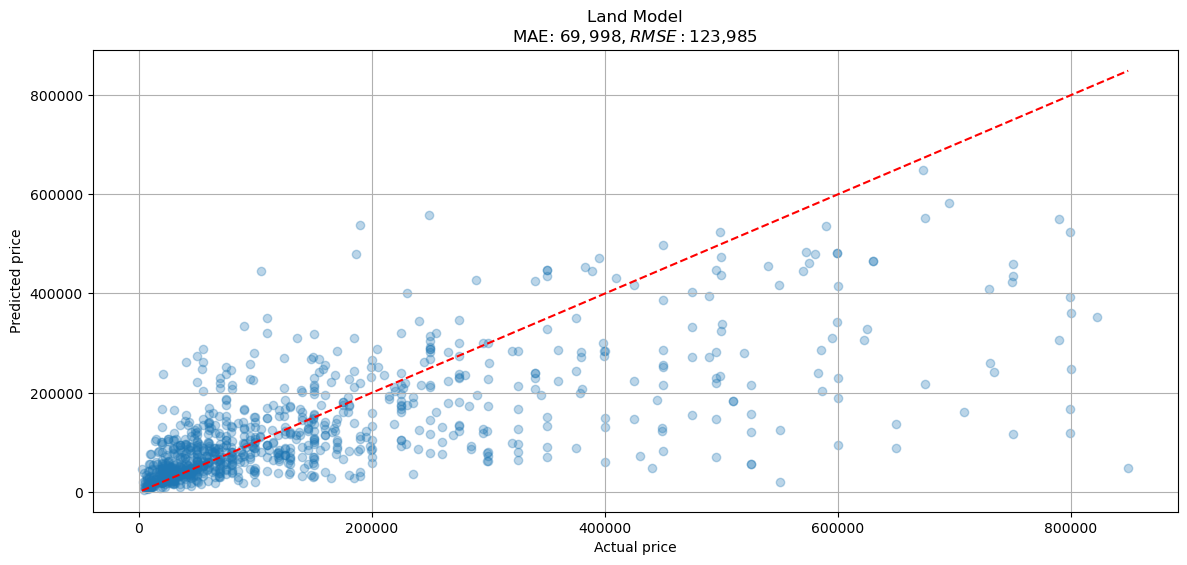

In [39]:
plt.figure(figsize=(14, 6))
plt.scatter(y_land_test_actual, y_land_pred, alpha=0.3)
plt.plot([y_land_test_actual.min(), y_land_test_actual.max()],
         [y_land_test_actual.min(), y_land_test_actual.max()],
         'r--')
plt.title(f"Land Model\nMAE: ${mae_land:,.0f}, RMSE: ${rmse_land:,.0f}")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.grid(True)
plt.show()


 ### **Prediction Function Overview**

- The final prediction functions takes in a user's preferences (like number of beds, baths, square footage, acreage, and desired property type) and returns a ranked list of top listings based on predicted price per square foot.

- By predicting price `efficiency rather than total price`, the function helps identify properties that offer the `best value for the user's criteria.`

- The model uses a trained Random Forest to estimate the price per square foot, then multiplies it by the actual square footage of each listing to estimate total price.

- Listings are then filtered and sorted to highlight the most `affordable and desirable options`, matching the user's preferences while `emphasizing value.`

- This approach enables smarter home discovery by prioritizing properties that deliver more for their cost.

In [90]:
def recommend_top_properties(df, model, features,
                             min_beds=3, max_beds=5,
                             min_baths=2, max_baths=4,
                             min_price=0, max_price=600000,
                             allowed_types=None,
                             min_acres=0.0, max_acres=10.0,
                             min_year_built=1950,
                             min_square_feet=1000, max_square_feet=5000,
                             hoa_allowed=True,
                             city=None,
                             top_n=5):

    if allowed_types is None:
        allowed_types = ["property_type_Single Family", "property_type_Townhouse"]

    # City filter (can be str or list)
    if city:
        if isinstance(city, str):
            city_filter = (df["city"] == city)
        else:
            city_filter = df["city"].isin(city)
    else:
        city_filter = True  # No city filter if not provided

    # HOA filter
    hoa_filter = (df["hoa_per_month"] >= 0) if hoa_allowed else (df["hoa_per_month"] == 0)

    filters = (
        (df["beds"] >= min_beds) &
        (df["beds"] <= max_beds) &
        (df["baths"] >= min_baths) &
        (df["baths"] <= max_baths) &
        (df["price"] >= min_price) &
        (df["price"] <= max_price) &
        (df["acres"] >= min_acres) & (df["acres"] <= max_acres) &
        (df["year_built"] >= min_year_built) &
        (df["square_feet"] >= min_square_feet) & (df["square_feet"] <= max_square_feet) &
        (df[allowed_types].any(axis=1)) &
        hoa_filter &
        city_filter
    )

    filtered_df = df[filters].copy()

    if filtered_df.empty:
        return "No matching homes found.(widen search)"

    # Predict log(price_per_sqft), then convert to actual values
    X_input = filtered_df[features]
    filtered_df["predicted_ppsqft"] = np.expm1(model.predict(X_input))
    filtered_df["predicted_price"] = filtered_df["predicted_ppsqft"] * filtered_df["square_feet"]

    return filtered_df.sort_values(by="predicted_price").head(top_n)[
    ["address", "city", "beds", "baths", "square_feet", "price"]
]



In [98]:
top_homes = recommend_top_properties(
    df_home,
    model_prop,
    features_property,
    min_beds=3,
    max_beds=5,
    min_baths=3,
    max_baths=5,
    min_price=50000,
    max_price=600000,
    city= [], # you can input any city in Virginia ("Abingdon","Williamsburg" etc)
    allowed_types=["property_type_Townhouse", "property_type_Condo", "property_type_Single Family",
    "property_type_Multi-Family", "property_type_Ranch"], # this includes all house types, remove undesired ones
    min_acres=2.0,
    max_acres=100.0,
    min_year_built=0,
    min_square_feet=0,
    max_square_feet=5000,
    hoa_allowed=False,
    top_n=5
)

top_homes[["address", "city", "beds", "baths", "square_feet", "price"]]


,address,city,beds,baths,square_feet,price
17020,10 Maplewood Dr,South Boston,4.0,3.0,1771.0,170000
19355,1658 Jakes Fork Rd,Vansant,5.0,3.0,2850.0,179000
8101,5290 Crumptown Rd,Farmville,3.0,3.0,2497.0,199999
18553,124 Sunset Dr,Stuart,4.0,3.0,2777.0,238900
9949,2149 Cowford Rd,Halifax,3.0,3.0,2000.0,449900


In [42]:
def recommend_top_land(df, model, features,
                       min_acres=0.0, max_acres=10.0,
                       min_price=0, max_price=600000,
                       city=None,
                       top_n=5):

    # City filter
    if city:
        if isinstance(city, str):
            city_filter = (df["city"] == city)
        else:
            city_filter = df["city"].isin(city)
    else:
        city_filter = True

    # Build filters (skip property_type_Land)
    filters = (
        (df["price"] >= min_price) &
        (df["price"] <= max_price) &
        (df["acres"] >= min_acres) &
        (df["acres"] <= max_acres) &
        (df["acres"] > 0) &
        city_filter
    )

    filtered_df = df[filters].copy()

    if filtered_df.empty:
        return "No land areas found.(widen search)"

    # Predict log(price), convert to actual price
    X_input = filtered_df[features]
    filtered_df["predicted_price"] = np.expm1(model.predict(X_input))

    # Sort by predicted price but return actual listing price
    return filtered_df.sort_values(by="predicted_price").head(top_n)[
        ["address", "city", "acres", "price"]
    ]


In [97]:
top_land = recommend_top_land(
    df_land,
    model_land,
    features_land,
    min_acres=5.0,
    max_acres=100.0,
    min_price=25000,
    max_price=150000,
    city=[], # input any cities inside of Virginia
    top_n=5 # number of predicted output values
)

display(top_land)


,address,city,acres,price
13837,20 High Valley South,Monterey,5.00,25000
13813,High Valley South,Monterey,5.02,28000
3219,0 Hunter Rd,Brookneal,5.11,29900
17922,TBD Georges Run Rd,Shawsville,5.72,28000
4948,00 Bearskin Rd,Chatham,5.01,29900


# **Key Takeaways**

- Encoding city-level pricing significantly boosted model accuracy by capturing local market trends in a numerical format the model could interpret.

- Log-transforming the target variable `price_per_sqft` helped reduce skew and made the prediction task easier by `compressing extreme values` and clarifying overall pricing patterns.

- Property size, number of bathrooms, and location were among the most influential features in determining price per square foot.

- Modeling `price_per_sqft` allowed for value-based comparisons across properties of different sizes, helping users identify listings that offer more for their money.

- For production deployment, predicting `log(price)` may offer more intuitive outputs while preserving modeling stability.

- A future model is planned to directly predict total home prices based on property dimensions and location.


This notebook serves as a clean, modular implementation of the ML modeling process within the broader housing recommendation system.